Important resources:

DEMOGRAPHICS DATASET

https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-detail.html
scroll down to "Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2020 to July 1, 2022 (CC-EST2022-ALLDATA)"
and click "United States" to download csv file for county demographics (name of file should be cc-est2022-all.csv)

https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/cc-est2022-alldata.pdf this shows what each column name means in terms of demographics 

NRI DATASET

https://hazards.fema.gov/nri/data-resources#csvDownload 
scroll down to "Table Format (CSV)" and click "All Counties - Country-level detail (Table)" and name of folder should be NRI_Table_Counties. the csv file has the same name  within the folder (NRI_Table_Counties.csv) 


In [339]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [340]:
#read national risk index dataset into the nri dataframe
nri = pd.read_csv("NRI_Table_Counties/NRI_Table_Counties.csv")
display(nri)
print(nri.columns)

#only include important columns
nri = nri[["NRI_ID", "STATE", "COUNTY", "POPULATION", "RISK_VALUE", "RISK_SCORE", "RISK_RATNG"]]

#nri has some extra territories, so let's define it in a list...
territories = ["American Samoa", "Guam", "Northern Mariana Islands", "Puerto Rico", "Virgin Islands"]
#...and get rid of the rows with these territories using .drop()
nri = nri.drop(nri[nri["STATE"].isin(territories)].index)

#now we should only have the 50 states + DC
nri
nricopy = nri.copy(deep=True)


,OID_,NRI_ID,STATE,STATEABBRV,STATEFIPS,COUNTY,COUNTYTYPE,COUNTYFIPS,STCOFIPS,POPULATION,...,WNTW_EALS,WNTW_EALR,WNTW_ALRB,WNTW_ALRP,WNTW_ALRA,WNTW_ALR_NPCTL,WNTW_RISKV,WNTW_RISKS,WNTW_RISKR,NRI_VER
0,1,C01001,Alabama,AL,1,Autauga,County,1,1001,58764,...,15.784587,Very Low,2.687716e-07,7.410082e-09,8.725777e-06,10.461158,8494.906508,12.217626,Very Low,March 2023
1,2,C01003,Alabama,AL,1,Baldwin,County,3,1003,231365,...,56.205509,Relatively Moderate,1.268231e-09,2.287120e-08,1.548360e-07,13.339523,65619.701638,52.083996,Relatively Low,March 2023
2,3,C01005,Alabama,AL,1,Barbour,County,5,1005,25160,...,18.632002,Relatively Low,5.788050e-07,2.347236e-08,7.606598e-07,16.125039,15501.730335,19.535476,Very Low,March 2023
3,4,C01007,Alabama,AL,1,Bibb,County,7,1007,22239,...,13.308573,Very Low,9.014679e-07,1.270300e-08,1.202015e-05,16.991643,7496.186940,11.104041,Very Low,March 2023
4,5,C01009,Alabama,AL,1,Blount,County,9,1009,58992,...,23.645930,Relatively Low,5.268425e-07,1.482016e-08,2.002965e-07,12.039616,17175.160729,21.444480,Very Low,March 2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3227,C72151,Puerto Rico,PR,72,Yabucoa,Municipio,151,72151,30397,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3227,3228,C72153,Puerto Rico,PR,72,Yauco,Municipio,153,72153,34151,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3228,3229,C78010,Virgin Islands,VI,78,St. Croix,Island,10,78010,40913,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3229,3230,C78020,Virgin Islands,VI,78,St. John,Island,20,78020,3882,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023


Index(['OID_', 'NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY',
       'COUNTYTYPE', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       ...
       'WNTW_EALS', 'WNTW_EALR', 'WNTW_ALRB', 'WNTW_ALRP', 'WNTW_ALRA',
       'WNTW_ALR_NPCTL', 'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER'],
      dtype='object', length=465)


In [341]:
#read demographics dataset into the demo dataframe
#the encoding part is because python reads in a specific encoding of the file, but file isn't in that form, so this fixes that
demo = pd.read_csv("cc-est2022-all.csv", encoding='iso-8859-1').dropna()

#making demo only include year 4, which is population estimate from 7/1/2022
demo = demo[(demo.YEAR == 4)]

#each county also had "County" at the end, so let's remove that and put them in a new column that is clearer
demo['COUNTY'] = demo['CTYNAME'].str.replace(" County", "")

#making new column for states bc "stname" is stupid
demo["STATE"] = demo["STNAME"]

#context: each county has several rows, 1 for each age-group
#using .groupby() to combine all the age groups so each county takes up 1 row
#using sort=False to keep them in the same orders
demo = demo.groupby(["COUNTY", "STATE"], sort=False).agg("sum").reset_index()

#removing the columns we don't need
demo = demo.drop(["STNAME","CTYNAME","SUMLEV","AGEGRP"], axis=1)

In [342]:
#displaying the rows in nri that are in connecticut
nri[nri.STATE == "Connecticut"]
#these need to get FIXED

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
309,C09001,Connecticut,Fairfield,957322,1.084730e+08,95.450207,Relatively High
310,C09003,Connecticut,Hartford,898547,5.277812e+07,91.473115,Relatively Moderate
311,C09005,Connecticut,Litchfield,185062,2.323207e+07,82.500795,Relatively Low
312,C09007,Connecticut,Middlesex,164179,1.843823e+07,78.364620,Relatively Low
313,C09009,Connecticut,New Haven,864495,8.602981e+07,94.463888,Relatively Moderate
314,C09011,Connecticut,New London,268434,3.323352e+07,87.368756,Relatively Moderate
315,C09013,Connecticut,Tolland,149768,1.089484e+07,67.069679,Relatively Low
316,C09015,Connecticut,Windham,116384,1.178378e+07,69.519567,Relatively Low


In [343]:
#displaying the rows in demo that are in connecticut
demo[demo.STATE == "Connecticut"]

#main problem: when connecticut in nri has 8 counties, and 9 planning regions in demo
#this means the number of rows connecticut has in each dataframe isn't the same so we need to fix that


,COUNTY,STATE,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
309,Capitol Planning Region,Connecticut,76,1962894,958518,1004376,717904,751916,143094,154612,...,145496,151496,30172,33394,6944,7292,2776,2510,1772,1216
310,Greater Bridgeport Planning Region,Connecticut,76,654572,320890,333682,248442,254362,44642,49930,...,60664,60016,8760,9184,2666,2416,972,874,444,412
311,Lower Connecticut River Valley Planning Region,Connecticut,76,353244,173998,179246,153004,157306,10282,10470,...,10870,11470,1954,2108,516,558,220,226,106,102
312,Naugatuck Valley Planning Region,Connecticut,76,908166,443490,464676,342928,356634,65120,70650,...,77014,77646,14406,15042,3642,3576,1100,996,516,514
313,Northeastern Connecticut Planning Region,Connecticut,76,192392,96294,96098,87910,88350,3250,2648,...,9688,9054,1492,1468,630,614,254,170,144,94
314,Northwest Hills Planning Region,Connecticut,76,226468,112470,113998,97924,99418,7586,7522,...,10972,11130,2048,2164,616,588,208,182,102,104
315,South Central Connecticut Planning Region,Connecticut,76,1146488,553704,592784,424880,450198,82598,92734,...,92058,94924,16700,18046,4576,4666,1310,1226,668,610
316,Southeastern Connecticut Planning Region,Connecticut,76,560806,280286,280520,233018,235464,20670,18108,...,27356,26774,6350,6044,2386,2542,842,764,414,276
317,Western Connecticut Planning Region,Connecticut,76,1247380,612858,634522,487314,496002,70538,79868,...,113324,113280,14404,15892,4932,4674,1788,1642,838,734


In [344]:
#editing each CT county in nri to match planning regions and the associated counties

#connecticut: county | planning region associated (figured out by matching their locations)
#litchfield | northwestern
#hartford + tolland | capitol
#windham | northeastern
#fairfield | western + greater bridgeport
#new haven | naugatuck + south central
#middlesex | lower connecticut
#new london | southeastern

#for planning regions that had more than 1 county associated with it, the values for those counties were averages and put into the planning region

bridgeport = nri.loc[30].RISK_VALUE #used this to format everything in nri to be in scientific notation with the +e
nri.loc[309] = {"STATE":"Connecticut","COUNTY":"Capitol Planning Region", "RISK_VALUE":(5.277812e+07 + 1.089484e+07)/2, "RISK_SCORE": (91.473115+67.069679)/2, "RISK_RATNG":"Relatively Low"}
nri.loc[310] = {"STATE":"Connecticut","COUNTY":"Greater Bridgeport Planning Region", "RISK_VALUE":bridgeport, "RISK_SCORE": 95.450207	, "RISK_RATNG":"Relatively High"}
nri.loc[311] = {"STATE":"Connecticut","COUNTY":"Lower Connecticut River Valley Planning Region", "RISK_VALUE":1.843823e+07, "RISK_SCORE": 78.364620, "RISK_RATNG":"Relatively Low"}
nri.loc[312] = {"STATE":"Connecticut","COUNTY":"Naugatuck Valley Planning Region", "RISK_VALUE":8.602981e+07, "RISK_SCORE": 94.463888, "RISK_RATNG":"Relatively Moderate"}
nri.loc[313] = {"STATE":"Connecticut","COUNTY":"Northeastern Connecticut Planning Region", "RISK_VALUE":1.178378e+07, "RISK_SCORE":69.519567, "RISK_RATNG":"Relatively Low"}
nri.loc[314] = {"STATE":"Connecticut","COUNTY":"Northwest Hills Planning Region", "RISK_VALUE":2.323207e+07, "RISK_SCORE": 82.500795, "RISK_RATNG":"Relatively Low"}
nri.loc[315] = {"STATE":"Connecticut","COUNTY":"South Central Connecticut Planning Region", "RISK_VALUE":8.602981e+07, "RISK_SCORE": 94.463888, "RISK_RATNG":"Relatively Moderate"}
nri.loc[316] = {"STATE":"Connecticut","COUNTY":"Southeastern Connecticut Planning Region", "RISK_VALUE":3.323352e+07, "RISK_SCORE": 87.368756, "RISK_RATNG":"Relatively Moderate"}

#adding new row in nri to be the western planning region
nri.loc[316.5] = {"STATE":"Connecticut","COUNTY":"Western Planning Region", "RISK_VALUE":bridgeport, "RISK_SCORE": 95.450207	, "RISK_RATNG":"Relatively High"}
nri = nri.sort_index().reset_index(drop=True)

nri[nri.STATE == "Connecticut"] #all good


,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
309,NaN,Connecticut,Capitol Planning Region,NaN,3.183648e+07,79.271397,Relatively Low
310,NaN,Connecticut,Greater Bridgeport Planning Region,NaN,1.045320e+07,95.450207,Relatively High
311,NaN,Connecticut,Lower Connecticut River Valley Planning Region,NaN,1.843823e+07,78.364620,Relatively Low
312,NaN,Connecticut,Naugatuck Valley Planning Region,NaN,8.602981e+07,94.463888,Relatively Moderate
313,NaN,Connecticut,Northeastern Connecticut Planning Region,NaN,1.178378e+07,69.519567,Relatively Low
314,NaN,Connecticut,Northwest Hills Planning Region,NaN,2.323207e+07,82.500795,Relatively Low
315,NaN,Connecticut,South Central Connecticut Planning Region,NaN,8.602981e+07,94.463888,Relatively Moderate
316,NaN,Connecticut,Southeastern Connecticut Planning Region,NaN,3.323352e+07,87.368756,Relatively Moderate
317,NaN,Connecticut,Western Planning Region,NaN,1.045320e+07,95.450207,Relatively High


In [345]:
#THIS ONLY RUNS PROPERLY WHEN THE NRI DATASET IS FIXED IN THE PREVIOUS CELL
#this is because .compare() requires the length of the datasets to be the same, but originally, demo had 1 more row than nri from the connecticut problem

#use differences to see how each dataset named counties differently (basically same name but different format for most)
differences = demo["COUNTY"].compare(nri["COUNTY"])
differences

#simple differences in names are alaska, lousiana, virginia
#differences are alaska + connecticut, which set delaware, dc, florida, etc off balance

,self,other
67,Aleutians East Borough,Aleutians East
68,Aleutians West Census Area,Aleutians West
69,Anchorage Municipality,Anchorage
70,Bethel Census Area,Bethel
71,Bristol Bay Borough,Bristol Bay
...,...,...
2950,Suffolk city,Suffolk
2951,Virginia Beach city,Virginia Beach
2952,Waynesboro city,Waynesboro
2953,Williamsburg city,Williamsburg


In [346]:
#merging both dataframes so we can work with 1 big one
df = pd.merge(demo, nri, left_index=True, right_index=True)
df

,COUNTY_x,STATE_x,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,NRI_ID,STATE_y,COUNTY_y,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
0,Autauga,Alabama,76,119518,58210,61308,44052,45342,11912,13606,...,44,44,38,C01001,Alabama,Autauga,58764.0,6.156054e+06,49.220490,Relatively Low
1,Baldwin,Alabama,76,492870,240328,252542,210450,220288,20202,21316,...,264,176,172,C01003,Alabama,Baldwin,231365.0,2.106327e+08,97.709195,Relatively High
2,Barbour,Alabama,76,49412,26128,23284,12846,11452,12434,11144,...,18,66,36,C01005,Alabama,Barbour,25160.0,7.412840e+06,56.188355,Relatively Low
3,Bibb,Alabama,76,44010,23550,20460,17274,16400,5728,3518,...,20,38,12,C01007,Alabama,Bibb,22239.0,3.863747e+06,32.484887,Very Low
4,Blount,Alabama,76,119024,59166,59858,56300,57236,1280,1030,...,58,74,56,C01009,Alabama,Blount,58992.0,1.023854e+07,65.128858,Relatively Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Sweetwater,Wyoming,76,82690,42938,39752,40272,37364,646,448,...,86,44,44,C56037,Wyoming,Sweetwater,42238.0,1.189081e+06,6.617881,Very Low
3140,Teton,Wyoming,76,46574,24412,22162,23040,20832,220,172,...,44,26,26,C56039,Wyoming,Teton,23250.0,1.141156e+07,68.501432,Relatively Low
3141,Uinta,Wyoming,76,41424,21196,20228,20240,19240,146,126,...,32,12,14,C56041,Wyoming,Uinta,20412.0,2.821381e+06,21.699014,Very Low
3142,Washakie,Wyoming,76,15438,7946,7492,7510,7068,52,32,...,16,12,4,C56043,Wyoming,Washakie,7662.0,6.211963e+05,2.513522,Very Low


NEXT STEPS:

1. choose which columns to keep (county, state, total pop, demographics, risk value + score + rating)

1a. demographics to keep: use the "alone or in combination" to include more people (even though it might double count)

how we should rename = how it is named in demo

WHITE_M = WAC_MALE

WHITE_F = WAC_FEMALE

BLACK_M = BAC_MALE

BLACK_F = BAC_FEMALE

NATIVE_M = IAC_MALE

NATIVE_F = IAC_FEMALE

ASIAN_M = AAC_MALE

ASIAN_F = AAC_FEMALE

HAW_PACIF_M = NAC_MALE

HAW_PACIF_F = NAC_FEMALE

HISP_M = H_MALE

HISP_F = H_FEMALE

Also maybe keep TOT_MALE and TOT_FEMALE ??

2. rename column names to be more clear
3. add new columns and calculate percentages of each
4. possibly a basic visualization of this all

In [347]:
#calculate each race percentage per county

df['PERCENT_WHITE'] = (df['WA_FEMALE'] + df['WA_MALE']) / df['TOT_POP']
df['PERCENT_BLACK'] = (df['BA_FEMALE'] + df['BA_MALE']) / df['TOT_POP']
df['PERCENT_ASIAN'] = (df['AA_FEMALE'] + df['AA_MALE']) / df['TOT_POP']
df['PERCENT_NATIVE'] = (df['NA_FEMALE'] + df['NA_MALE']) / df['TOT_POP']
df['PERCENT_HISP'] = (df['H_FEMALE'] + df['H_MALE']) / df['TOT_POP']
df['PERCENT_HAW'] = (df['NAC_FEMALE'] + df['NAC_MALE']) / df['TOT_POP']

#white or non-white majority column
df['MAJORITY_RACE'] = df.apply(lambda _: '', axis=1)
df.loc[df['PERCENT_WHITE'] > 0.5, 'MAJORITY_RACE'] = 'WHITE'
df.loc[df['PERCENT_WHITE'] <= 0.5, 'MAJORITY_RACE'] = 'MINORITY'

df

,COUNTY_x,STATE_x,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,RISK_VALUE,RISK_SCORE,RISK_RATNG,PERCENT_WHITE,PERCENT_BLACK,PERCENT_ASIAN,PERCENT_NATIVE,PERCENT_HISP,PERCENT_HAW,MAJORITY_RACE
0,Autauga,Alabama,76,119518,58210,61308,44052,45342,11912,13606,...,6.156054e+06,49.220490,Relatively Low,0.747954,0.213508,0.011781,0.001222,0.033819,0.002192,WHITE
1,Baldwin,Alabama,76,492870,240328,252542,210450,220288,20202,21316,...,2.106327e+08,97.709195,Relatively High,0.873938,0.084237,0.011561,0.000665,0.050362,0.002414,WHITE
2,Barbour,Alabama,76,49412,26128,23284,12846,11452,12434,11144,...,7.412840e+06,56.188355,Relatively Low,0.491743,0.477172,0.004695,0.002793,0.051000,0.004048,MINORITY
3,Bibb,Alabama,76,44010,23550,20460,17274,16400,5728,3518,...,3.863747e+06,32.484887,Very Low,0.765144,0.210089,0.002908,0.001318,0.031766,0.001954,WHITE
4,Blount,Alabama,76,119024,59166,59858,56300,57236,1280,1030,...,1.023854e+07,65.128858,Relatively Low,0.953892,0.019408,0.004352,0.001311,0.100702,0.001949,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Sweetwater,Wyoming,76,82690,42938,39752,40272,37364,646,448,...,1.189081e+06,6.617881,Very Low,0.938880,0.013230,0.009143,0.001621,0.166453,0.003048,WHITE
3140,Teton,Wyoming,76,46574,24412,22162,23040,20832,220,172,...,1.141156e+07,68.501432,Relatively Low,0.941985,0.008417,0.018809,0.001589,0.157642,0.003264,WHITE
3141,Uinta,Wyoming,76,41424,21196,20228,20240,19240,146,126,...,2.821381e+06,21.699014,Very Low,0.953071,0.006566,0.005939,0.001593,0.101053,0.003911,WHITE
3142,Washakie,Wyoming,76,15438,7946,7492,7510,7068,52,32,...,6.211963e+05,2.513522,Very Low,0.944293,0.005441,0.008680,0.000907,0.141728,0.002721,WHITE


In [348]:
#simply playing around, ignore this

'''
dfMin = df[df.MAJORITY_RACE=="MINORITY"]

dfMin.plot.scatter(x="PERCENT_WHITE", y="RISK_SCORE")
dfMin.plot.scatter(x="PERCENT_BLACK", y="RISK_SCORE")
dfMin.plot.scatter(x="PERCENT_HAW", y="RISK_SCORE")
dfMin.plot.scatter(x="PERCENT_HISP", y="RISK_SCORE")
dfMin.plot.scatter(x="PERCENT_ASIAN", y="RISK_SCORE")
dfMin.plot.scatter(x="PERCENT_NATIVE", y="RISK_SCORE")
'''


'\ndfMin = df[df.MAJORITY_RACE=="MINORITY"]\n\ndfMin.plot.scatter(x="PERCENT_WHITE", y="RISK_SCORE")\ndfMin.plot.scatter(x="PERCENT_BLACK", y="RISK_SCORE")\ndfMin.plot.scatter(x="PERCENT_HAW", y="RISK_SCORE")\ndfMin.plot.scatter(x="PERCENT_HISP", y="RISK_SCORE")\ndfMin.plot.scatter(x="PERCENT_ASIAN", y="RISK_SCORE")\ndfMin.plot.scatter(x="PERCENT_NATIVE", y="RISK_SCORE")\n'

In [349]:
dfSpecific = df[["PERCENT_WHITE", "PERCENT_ASIAN", "PERCENT_BLACK", "PERCENT_HISP", "PERCENT_HAW", "PERCENT_NATIVE", "RISK_SCORE", "RISK_VALUE"]]
dfSpecific.corr()

#this shows the correlation coefficients between risk and demo are weak so we must reroute

,PERCENT_WHITE,PERCENT_ASIAN,PERCENT_BLACK,PERCENT_HISP,PERCENT_HAW,PERCENT_NATIVE,RISK_SCORE,RISK_VALUE
PERCENT_WHITE,1.000000,-0.269097,-0.820796,0.030390,-0.155183,-0.119028,-0.246450,-0.111070
PERCENT_ASIAN,-0.269097,1.000000,0.037307,0.167126,0.332758,0.239195,0.334188,0.343190
PERCENT_BLACK,-0.820796,0.037307,1.000000,-0.086303,-0.037585,-0.029391,0.241951,0.053993
PERCENT_HISP,0.030390,0.167126,-0.086303,1.000000,0.052576,0.041363,0.202545,0.184662
PERCENT_HAW,-0.155183,0.332758,-0.037585,0.052576,1.000000,0.881015,0.049282,0.039532
PERCENT_NATIVE,-0.119028,0.239195,-0.029391,0.041363,0.881015,1.000000,0.042473,0.032544
RISK_SCORE,-0.246450,0.334188,0.241951,0.202545,0.049282,0.042473,1.000000,0.271043
RISK_VALUE,-0.111070,0.343190,0.053993,0.184662,0.039532,0.032544,0.271043,1.000000



ALL OF THE VISUALIZATIONS WILL BE FIXED LATER!

In [350]:
#this code is used to get a txt file from the internet in order to convert it to a csv file
#txt file contains geoids associated with each county
#we need geoids so we can merge it into our df
#we need to do that because to use geopandas, we need some sort of common column to associate the location of a county with the county itself
#"easiest" (the most mentally sane) way is by using a geoid

import requests

url = "https://www2.census.gov/geo/docs/reference/county_adjacency/county_adjacency2023.txt"
response = requests.get(url)
if response.status_code == 200:
    with open("geoid.txt", "wb") as file:
        file.write(response.content)
    geoid = pd.read_csv("geoid.txt", delimiter="\|")
    geoid.to_csv("geoid.csv", index=False)
    print(geoid)
else: #just making sure it actually worked
    print("fail")

                 County Name  County GEOID          Neighbor Name  \
0         Autauga County, AL          1001     Autauga County, AL   
1         Autauga County, AL          1001     Chilton County, AL   
2         Autauga County, AL          1001      Dallas County, AL   
3         Autauga County, AL          1001      Elmore County, AL   
4         Autauga County, AL          1001     Lowndes County, AL   
...                      ...           ...                    ...   
22192   St. Croix Island, VI         78010   St. Croix Island, VI   
22193    St. John Island, VI         78020    St. John Island, VI   
22194    St. John Island, VI         78020  St. Thomas Island, VI   
22195  St. Thomas Island, VI         78030    St. John Island, VI   
22196  St. Thomas Island, VI         78030  St. Thomas Island, VI   

       Neighbor GEOID  
0                1001  
1                1021  
2                1047  
3                1051  
4                1085  
...               ...  
221

/var/folders/56/8k094n4n209cyjwbsvsvrhlw0000gp/T/ipykernel_15890/1200954790.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  geoid = pd.read_csv("geoid.txt", delimiter="\|")


In [351]:
#in geoid dataframe, there are a lot of repeats of rows (bc each row is a county that borders the main county)
#removing the repeats ("~" is like "!=") and the extra territories

geoid = geoid[~geoid.duplicated(subset='County GEOID', keep='first')].reset_index()
geoid["state"] = geoid["County Name"].str[-2:]
extraStates = ["AS", "GU", "PR", "MP", "VI"]
geoid = geoid.drop(geoid[geoid["state"].isin(extraStates)].index)
geoid

,index,County Name,County GEOID,Neighbor Name,Neighbor GEOID,state
0,0,"Autauga County, AL",1001,"Autauga County, AL",1001,AL
1,6,"Baldwin County, AL",1003,"Baldwin County, AL",1003,AL
2,13,"Barbour County, AL",1005,"Barbour County, AL",1005,AL
3,22,"Bibb County, AL",1007,"Bibb County, AL",1007,AL
4,29,"Blount County, AL",1009,"Blount County, AL",1009,AL
...,...,...,...,...,...,...
3139,21682,"Sweetwater County, WY",56037,"Moffat County, CO",8081,WY
3140,21691,"Teton County, WY",56039,"Bonneville County, ID",16019,WY
3141,21700,"Uinta County, WY",56041,"Rich County, UT",49033,WY
3142,21705,"Washakie County, WY",56043,"Big Horn County, WY",56003,WY


In [352]:
#nice thing about this geoid dataframe is that it has the same number of rows as df (bc both demo and geoid come from the us census)
#now we need to ensure the order of the counties in both is the same (which it should be bc they come from the same source)

#this is just test code to make sure that 
#select rows where values of 'county_x' in df contain values of 'county name' in geoid
#used to ensure that the counties match up (they do!!)
selected_rows = geoid[geoid['County Name'].apply(lambda x: any(item in x for item in df['COUNTY_x']))]
selected_rows #shows 3144 rows, meaning the counties match

wrong = geoid[~geoid['County Name'].apply(lambda x: any(item in x for item in df['COUNTY_x']))]
wrong #shows 0 rows, meaning that no counties mismatch

#GEOID in the shapefile is in the datatype String but is int in geoid, so we are just converting it to string
geoid["GEOID"] = geoid["County GEOID"].astype(str)

#in shapefile, it is 5 digits, so if the geoid is "1002", the format of the data value is "01002"
#this ensures all the values in our geoid df are formatted to have 0 in front if it has 4 digits to make it have 5 digits
def add_zero(value):
    if len(value) == 4:
        return '0' + value
    else:
        return value
geoid['GEOID'] = geoid['GEOID'].apply(add_zero)

#only want GEOID column
geoidFinal = geoid[["GEOID"]]
geoidFinal

,GEOID
0,01001
1,01003
2,01005
3,01007
4,01009
...,...
3139,56037
3140,56039
3141,56041
3142,56043


In [353]:
#now we merge geoid with df to create a df_with_geoid that has all the necessary data together
df_with_geoid = pd.merge(df, geoidFinal, left_index=True, right_index=True)
df_with_geoid

,COUNTY_x,STATE_x,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,RISK_SCORE,RISK_RATNG,PERCENT_WHITE,PERCENT_BLACK,PERCENT_ASIAN,PERCENT_NATIVE,PERCENT_HISP,PERCENT_HAW,MAJORITY_RACE,GEOID
0,Autauga,Alabama,76,119518,58210,61308,44052,45342,11912,13606,...,49.220490,Relatively Low,0.747954,0.213508,0.011781,0.001222,0.033819,0.002192,WHITE,01001
1,Baldwin,Alabama,76,492870,240328,252542,210450,220288,20202,21316,...,97.709195,Relatively High,0.873938,0.084237,0.011561,0.000665,0.050362,0.002414,WHITE,01003
2,Barbour,Alabama,76,49412,26128,23284,12846,11452,12434,11144,...,56.188355,Relatively Low,0.491743,0.477172,0.004695,0.002793,0.051000,0.004048,MINORITY,01005
3,Bibb,Alabama,76,44010,23550,20460,17274,16400,5728,3518,...,32.484887,Very Low,0.765144,0.210089,0.002908,0.001318,0.031766,0.001954,WHITE,01007
4,Blount,Alabama,76,119024,59166,59858,56300,57236,1280,1030,...,65.128858,Relatively Low,0.953892,0.019408,0.004352,0.001311,0.100702,0.001949,WHITE,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Sweetwater,Wyoming,76,82690,42938,39752,40272,37364,646,448,...,6.617881,Very Low,0.938880,0.013230,0.009143,0.001621,0.166453,0.003048,WHITE,56037
3140,Teton,Wyoming,76,46574,24412,22162,23040,20832,220,172,...,68.501432,Relatively Low,0.941985,0.008417,0.018809,0.001589,0.157642,0.003264,WHITE,56039
3141,Uinta,Wyoming,76,41424,21196,20228,20240,19240,146,126,...,21.699014,Very Low,0.953071,0.006566,0.005939,0.001593,0.101053,0.003911,WHITE,56041
3142,Washakie,Wyoming,76,15438,7946,7492,7510,7068,52,32,...,2.513522,Very Low,0.944293,0.005441,0.008680,0.000907,0.141728,0.002721,WHITE,56043


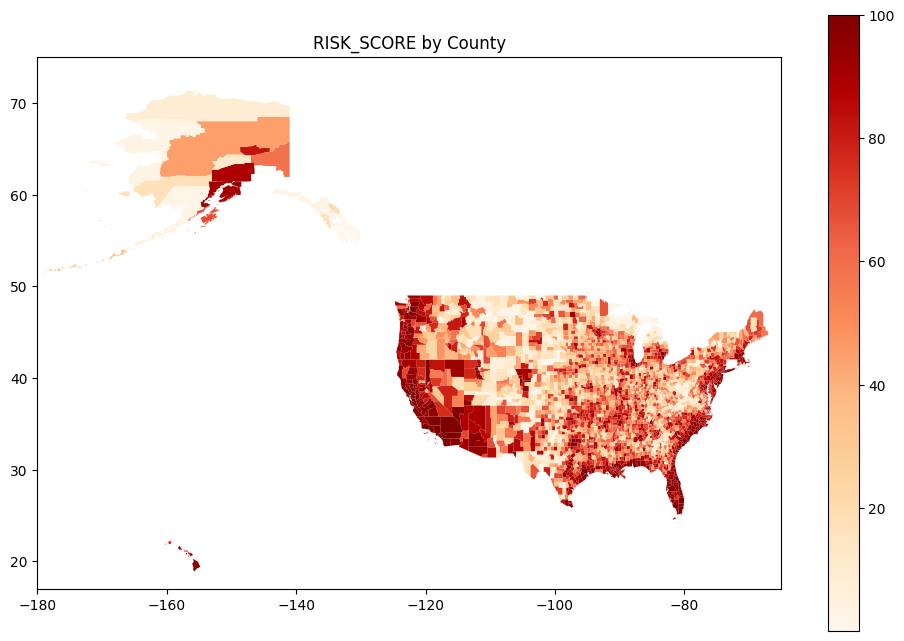

In [354]:
#using geopandas, we create an empty geospatial viz
gdf = gpd.read_file("cb_2018_us_county_500k.shp")

#merging our df_with_geoid and the empty geospatial viz
merged = gdf.merge(df_with_geoid, on='GEOID', how='left')

#filtering out extra
territory_statefps = ["72", "60", "69", "78", "66"]
merged_gdf = merged[~merged['STATEFP'].isin(territory_statefps)]

col_name = "RISK_SCORE"

#plotting specifically data in a column (i chose risk_score just to test)
us = merged_gdf.plot(column=col_name, cmap='OrRd', legend=True, figsize=(12, 8))
title = col_name + ' by County'
plt.title(title)

# set the extent to focus on the US
# main part of US is [-130,-65]x[24,50]
us.set_xlim([-180, -65])  
us.set_ylim([17, 75])    

#uncomment to see
plt.show()

#how do we know we're looking at correct code!!???
#when you go to the nri national map (https://hazards.fema.gov/nri/map) it shows the same map, just colors are diff :D

In [355]:

#manually set the center and zoom level to cover the entire United States
center = [45, -135]
zoom_level = 3

#create a Folium map centered around the entire United States
interactiveMap = folium.Map(location=center, zoom_start=zoom_level)

#add a choropleth layer for risk
folium.Choropleth(
    geo_data=merged_gdf,
    data=merged_gdf,
    columns=["NAME", 'RISK_SCORE'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_weight=1,
    legend_name='Risk Level',
    nan_fill_color='gray',  # gray places are NaN values
    nan_fill_opacity=0.4
).add_to(interactiveMap)

#add GeoJson layer with hover information
folium.GeoJson(
    merged_gdf,
    style_function=lambda feature: {
        'fillColor': 'transparent',  #set fill color to transparent
        'color': 'transparent',  #set border color to transparent
        'weight': 0,  #set border weight to 0
        'dashArray': '5, 5',
        'fillOpacity': 0.7 
    },
    highlight_function=lambda x: {'fillColor': 'lightblue', 'color': 'lightblue'},
    tooltip=folium.features.GeoJsonTooltip( #example fields, will change this later
        fields=["GEOID", 'NAME', 'STATE_x', 'RISK_SCORE', 'PERCENT_WHITE', 'PERCENT_BLACK', 'PERCENT_ASIAN'],
        aliases=["GeoID", 'County', 'State', 'Risk Score', 'Percent White', 'Percent Black', 'Percent Asian'],
        localize=True
    )
).add_to(interactiveMap)

#display the map (it won't let me upload file without commenting this out)
#interactiveMap


In [356]:
#check for NaN values in the 'RISK_SCORE' column
missing_data = merged_gdf[merged_gdf['RISK_SCORE'].isna()]
value_counts = missing_data['STATEFP'].value_counts()
print(value_counts)

#ok so these are the nan values
#02 = alaska
#09 = connecticut (fuck connecticut)


STATEFP
09    8
02    1
Name: count, dtype: int64


START READING POVERTY LEVELS HERE

In [357]:
#poverty of every county, both in total number and as a percent out of total population

pov = pd.read_csv("PovertyEstimates.csv")

pov = pov[(pov.FIPS_Code % 1000 != 0)].reset_index()
pov = pov[["FIPS_Code", "Stabr", "Area_name", "POV_all_ages", "POV_percent_all_ages"]]

pov

,FIPS_Code,Stabr,Area_name,POV_all_ages,POV_percent_all_ages
0,1001,AL,Autauga County,6296.0,10.7
1,1003,AL,Baldwin County,25526.0,10.8
2,1005,AL,Barbour County,5089.0,23.0
3,1007,AL,Bibb County,4204.0,20.6
4,1009,AL,Blount County,6992.0,12.0
...,...,...,...,...,...
3138,56037,WY,Sweetwater County,3761.0,9.2
3139,56039,WY,Teton County,1392.0,5.9
3140,56041,WY,Uinta County,1917.0,9.4
3141,56043,WY,Washakie County,773.0,10.2


extra stuff pls ignore

#nri order: fairfield, hartford, litchfield, middlesec, new haven, new london, tolland, windham
#demo order: capitol, greater bridgeport, lower connecticut, naugatuck, northeastern, northwest hills, south central, southwestern, western
#new demo: western, greater bridgeport, capitol, 


subset_demo = demo.loc[309:317]
numeric_columns = subset_demo.select_dtypes(include=['int', 'float']).columns
df2 = pd.DataFrame()
df2['COUNTY'] = subset_demo['COUNTY']
df2['Average'] = subset_demo[numeric_columns].mean(axis=1)
df2



In [358]:
nricopy #made this earlier so that we have the original copy we can use to merge since the connecticuts match in pov and nri

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
0,C01001,Alabama,Autauga,58764,6.156054e+06,49.220490,Relatively Low
1,C01003,Alabama,Baldwin,231365,2.106327e+08,97.709195,Relatively High
2,C01005,Alabama,Barbour,25160,7.412840e+06,56.188355,Relatively Low
3,C01007,Alabama,Bibb,22239,3.863747e+06,32.484887,Very Low
4,C01009,Alabama,Blount,58992,1.023854e+07,65.128858,Relatively Low
...,...,...,...,...,...,...,...
3138,C56037,Wyoming,Sweetwater,42238,1.189081e+06,6.617881,Very Low
3139,C56039,Wyoming,Teton,23250,1.141156e+07,68.501432,Relatively Low
3140,C56041,Wyoming,Uinta,20412,2.821381e+06,21.699014,Very Low
3141,C56043,Wyoming,Washakie,7662,6.211963e+05,2.513522,Very Low


In [359]:
#merging
pov_clean = pov[["FIPS_Code", "POV_all_ages", "POV_percent_all_ages"]]
pov_nri = pd.merge(nricopy, pov_clean, left_index=True, right_index=True)
pov_nri

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG,FIPS_Code,POV_all_ages,POV_percent_all_ages
0,C01001,Alabama,Autauga,58764,6.156054e+06,49.220490,Relatively Low,1001,6296.0,10.7
1,C01003,Alabama,Baldwin,231365,2.106327e+08,97.709195,Relatively High,1003,25526.0,10.8
2,C01005,Alabama,Barbour,25160,7.412840e+06,56.188355,Relatively Low,1005,5089.0,23.0
3,C01007,Alabama,Bibb,22239,3.863747e+06,32.484887,Very Low,1007,4204.0,20.6
4,C01009,Alabama,Blount,58992,1.023854e+07,65.128858,Relatively Low,1009,6992.0,12.0
...,...,...,...,...,...,...,...,...,...,...
3138,C56037,Wyoming,Sweetwater,42238,1.189081e+06,6.617881,Very Low,56037,3761.0,9.2
3139,C56039,Wyoming,Teton,23250,1.141156e+07,68.501432,Relatively Low,56039,1392.0,5.9
3140,C56041,Wyoming,Uinta,20412,2.821381e+06,21.699014,Very Low,56041,1917.0,9.4
3141,C56043,Wyoming,Washakie,7662,6.211963e+05,2.513522,Very Low,56043,773.0,10.2


In [360]:
#corr() only wants columns with numeric data

pov_nri_numerical = pov_nri[["RISK_VALUE", "RISK_SCORE", "POV_all_ages", "POV_percent_all_ages"]]
pov_nri_numerical.corr()
#STRONG CORRELATION BETWEEN POV_ALL_AGES AND RISK_VALUE !!!! 0.805

,RISK_VALUE,RISK_SCORE,POV_all_ages,POV_percent_all_ages
RISK_VALUE,1.000000,0.271444,0.805162,-0.040340
RISK_SCORE,0.271444,1.000000,0.347048,-0.047074
POV_all_ages,0.805162,0.347048,1.000000,-0.014050
POV_percent_all_ages,-0.040340,-0.047074,-0.014050,1.000000


In [361]:
#finding the random outlier that strengthened our r value
pov_nri[pov_nri.POV_all_ages > 1.2e6]

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG,FIPS_Code,POV_all_ages,POV_percent_all_ages
205,C06037,California,Los Angeles,10005712,5.326193e+09,100.0,Very High,6037,1365808.0,14.1


<Axes: xlabel='POV_all_ages', ylabel='RISK_VALUE'>

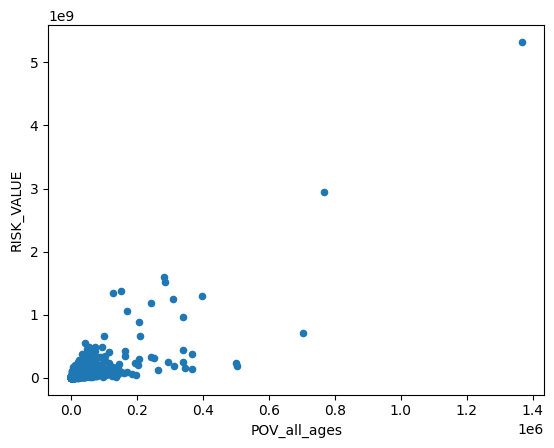

In [362]:
pov_nri.plot.scatter(x="POV_all_ages", y="RISK_VALUE")


NEXT STEPS
1. redo visualizations and stuff to make it seem better
2. potentially ML model regression of predicting risk based on number of people in poverty
3. reformat code to be clean and explained well
4. make a singular notebook the main code in the repo so if someone looks at the code they see a main thing and not people's folders
5. create github page in repo and do the presentation

In [363]:
#social vulnerability index??
#it relates to race https://www.atsdr.cdc.gov/placeandhealth/svi/index.html
svi = pd.read_csv("SVI_2020_US_county.csv")
svi
#if we even have time we could try and look at this as well

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1,Alabama,AL,1001,Autauga,1001,"Autauga County, Alabama",594.455838,55639,0,...,1.2,0.3,0.3,0.2,0.0,0.1,2.0,0.7,0.2,0.3
1,1,Alabama,AL,1003,Baldwin,1003,"Baldwin County, Alabama",1589.835294,218289,0,...,0.9,0.2,0.6,0.2,0.0,0.1,1.9,0.4,0.3,0.2
2,1,Alabama,AL,1005,Barbour,1005,"Barbour County, Alabama",885.007618,25026,0,...,0.5,0.1,0.3,0.3,0.0,0.1,1.3,0.6,0.6,0.4
3,1,Alabama,AL,1007,Bibb,1007,"Bibb County, Alabama",622.469288,22374,0,...,0.3,0.4,0.1,0.1,0.0,0.2,0.4,0.3,0.0,0.2
4,1,Alabama,AL,1009,Blount,1009,"Blount County, Alabama",644.890375,57755,0,...,0.4,0.1,0.1,0.1,0.1,0.1,1.8,0.3,0.3,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56,Wyoming,WY,56037,Sweetwater,56037,"Sweetwater County, Wyoming",10426.975770,43352,0,...,0.7,0.3,1.0,0.4,0.0,0.1,2.2,0.8,0.2,0.3
3139,56,Wyoming,WY,56039,Teton,56039,"Teton County, Wyoming",3996.846846,23356,0,...,1.4,0.8,0.2,0.2,0.1,0.1,1.0,0.6,0.6,0.8
3140,56,Wyoming,WY,56041,Uinta,56041,"Uinta County, Wyoming",2081.719808,20374,0,...,0.2,0.2,0.5,0.3,0.0,0.2,2.2,0.4,0.0,0.2
3141,56,Wyoming,WY,56043,Washakie,56043,"Washakie County, Wyoming",2238.678265,7933,0,...,0.0,0.4,0.4,0.4,0.0,0.4,3.2,0.5,0.4,0.4
